
# AI vs IA
---

#### Group 12

This notebook contains our work for the **AI vs IA** subject at the **IA Data Hack** hackaton.<br><br>
The structure is the following:
- Subject understanding
- Data analysis and transformation
- Models benchmark
- Best model optimisation
- Conclusion

We are using the library ```scikit-learn``` for a part of the benchmark, which runs only on CPU, so it takes a lot of time training different models.<br>
There will be the comment ```DO NOT RUN``` on specific part of the benchmark because it would be too long to run, you have to trust us on our result !

## Subject understanding
---

The subject of this hackaton is, as said before, **AI vs IA**. Given some text, we need to define if the sentence was created by a **human** or an **AI**.<br>
Therefore, we consider this problem as a ***classification*** problem, especially a ***binary classification*** problem. Binary classification is a common problem in artificial intelligence, which require ***machine learning*** or ***deep learning*** models. We will use both and compare them in our benchmark to get the best one.<br>
For binary classification problem, we use the ```binary cross entropy``` loss function, which is the most suitable, and calculated as follows:

$$
BCE = -y \cdot \log(p) - (1 - y) \cdot \log(1 - p)
$$

Where:
- *y* is the true label (0 or 1)
- *p* is the predicted probability (between 0 and 1)


## Data analysis and transformation
---

### Libraries import

In [11]:
import os

import pandas as pd
import s3fs
import zipfile

import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

#### Get dataset from aws

In [12]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [13]:
file_path = "data.csv"

# Télécharger les données dans le service
fs.download("civel/diffusion/hackathon-minarm-2024/AIVSAI/hack_train.csv", file_path)

[None]

In [14]:
df = pd.read_csv(file_path).drop(['src'], axis=1)

### Occurrences of words in errors

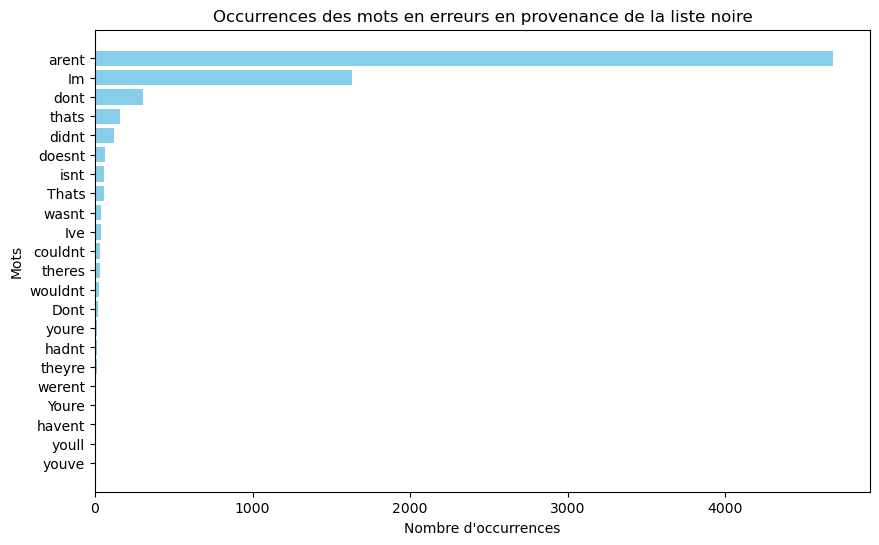

In [15]:
# Liste noire de mots à considérer comme des erreurs
blacklisted_words = {"didnt","dont","Im","youre","Ive","doesnt","wasnt","couldnt","wasnt","couldnt","thats","isnt","Thats","thats",
"theres","theyre","wouldnt","Youre","arent","youll","Dont","theres","youve","havent","hadnt","werent"
}

# Dictionnaire pour compter les occurrences des mots de la liste noire dans les textes
blacklisted_counts = {word: sum(text.count(word) for text in df['text']) for word in blacklisted_words}

# Filtrer les mots avec au moins une occurrence
filtered_counts = {word: count for word, count in blacklisted_counts.items() if count > 0}

# Trier dictionnaire par valeur pour obtenir les mots avec le plus d'occurrences
sorted_counts = sorted(filtered_counts.items(), key=lambda x: x[1], reverse=True)

# Extraction data pour graphique
words = [word for word, count in sorted_counts]
counts = [count for word, count in sorted_counts]

# tunning graphique 
plt.figure(figsize=(10, 6))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Nombre d\'occurrences')
plt.ylabel('Mots')
plt.title('Occurrences des mots en erreurs en provenance de la liste noire')
plt.gca().invert_yaxis()  # Inverser l'axe y pour avoir les mots les plus fréquents en haut
plt.show()


### word cloud : human responses

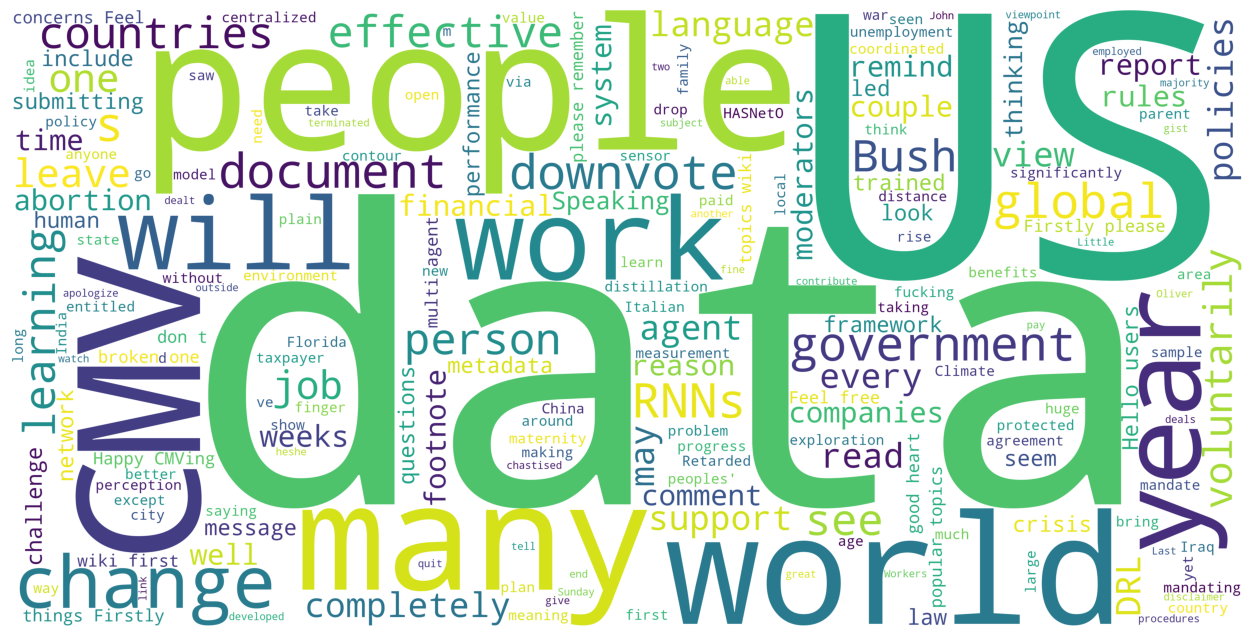

In [16]:
stopwords = set(STOPWORDS)
human = df[df['label'] == True]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

word cloud : AI responses

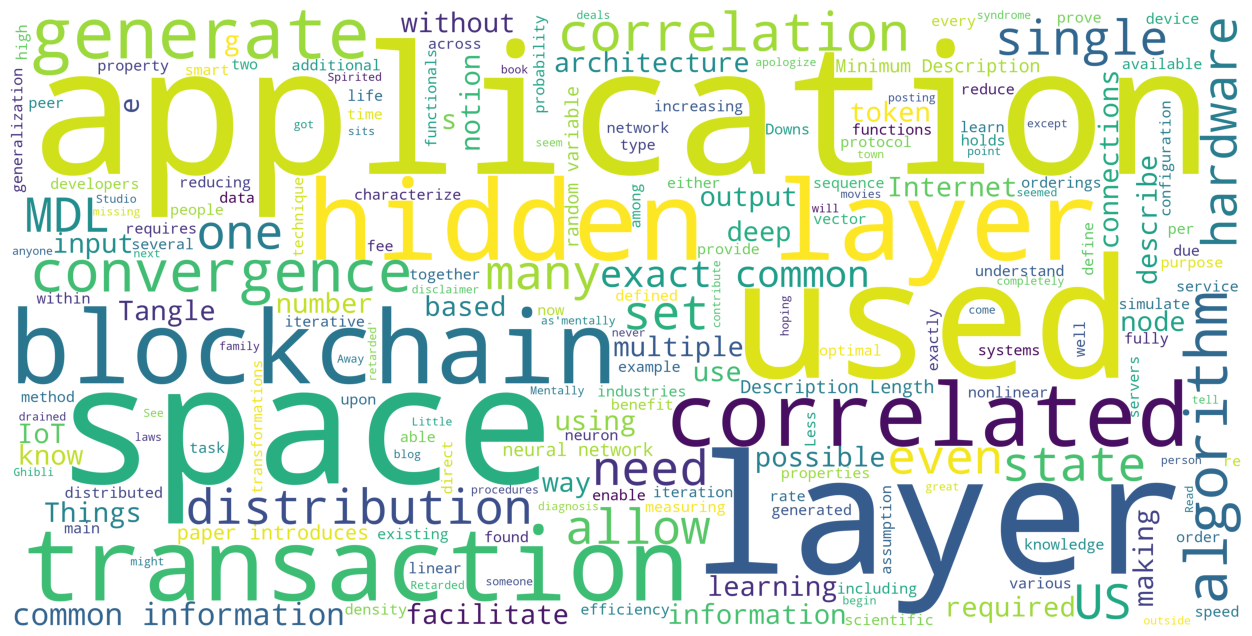

In [17]:
stopwords = set(STOPWORDS)
human = df[df['label'] == False]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Models benchmark
---

## Best model optimisation
---

## Conclusion
---